In [6]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
sns.set_palette('Set2')

In [4]:
path = 'forest_fire/data/new_data/'
list_of_files = os.listdir(path)
print(len(list_of_files))

247
247


In [7]:
def get_outbreaks(data, threshold=25):
    """
    Calculates the outbreaks from the actives data.

    Returns:
        - An array with the outbreak peak sizes.
        - An array with the outbreak durations.
        - An array of the outbreaks
    """
    outbreak_peaks = []
    outbreak_widths = []
    counting = False
    current_peak = 0
    start = 0

    for i in range(len(data)):

        if data[i] >= threshold and not counting:
            counting = True
            if current_peak < data[i]:
                current_peak = data[i]
            start = i

        elif data[i] >= threshold and counting:
            if current_peak < data[i]:
                current_peak = data[i]

        elif data[i] < threshold and counting:
            outbreak_peaks.append(current_peak)
            outbreak_widths.append(i-start)
            current_peak = 0
            counting = False

    # Capture cases where timeline ends in an outbreak.
    # Obviously skewers data, but preferable over 0 or infinite outbreaks.
    if not outbreak_peaks and counting:
        outbreak_peaks.append(current_peak)
        outbreak_widths.append(len(data))
    elif not outbreak_peaks and not counting:
        outbreak_peaks.append(0)
        outbreak_widths.append(0)

    return outbreak_peaks, outbreak_widths, list(range(len(outbreak_peaks)))

In [8]:
# The different comparisons are 
# - 100 vs 300 firefighters at strength 10
# - 100 firefighters, on multiple strengths 
# - different tactics

# for obvious reasons we only will compare the tactics on
#  300 strength. 
data = pd.DataFrame()
data_counter = pd.DataFrame()
for file in list_of_files:
    inputdf = pd.read_csv(path + '/' + file)
    inputdf.drop(['Unnamed: 0'], axis=1, inplace=True)
    
    if inputdf.empty == False:
        peaks, durations, numbers = get_outbreaks(inputdf['On fire'], threshold=750)
        df = pd.DataFrame(data={'FireSize': peaks,
                                'Duration': durations,
                                'Number': numbers})
        df_counter = pd.DataFrame(data={'Burning Trees':inputdf['On fire'],
                                        'Alive trees':inputdf['Fine'],
                                        'Fire count':inputdf['Nf'],
                                        'Min area':inputdf['min_fire_area'],
                                        'Max area':inputdf['max_fire_area'],
                                        'Median area':inputdf['median_fire_area'],
                                        'Mean area':inputdf['mean_fire_area'],
                                        'Timestep':inputdf['Ns'],
                                        })
        strats = ['biggest', 'closest', 'earliest', 'random', 'none']
        n_fighters = ['nfighters100', 'nfighters300', 'nfighters500', 'nfighters700', 'nfighters900']
        strengths = ['strength2', 'strength4', 'strength6', 'strength8', 'strength10']
        
        if 'nfighters0' in file:
            df['Strategy'] = 'No firefighters'
            df['N_firefighters'] = '0'
            df['Strength'] = '0'
            df_counter['Strategy'] = 'No firefighters'
            df_counter['N_firefighters'] = '0'
            df_counter['Strength'] = '0'
        else:
            
            for strat in strats:
                for fighter in n_fighters:
                    for strength in strengths:
                        if strat in file and fighter in file and strength in file:
                            df['Strategy'] = strat
                            df['N_firefighters'] = fighter
                            df['Strength'] = strength
                            df_counter['Strategy'] = strat
                            df_counter['N_firefighters'] = fighter
                            df_counter['Strength'] = strength

        data = data.append(df)
        data_counter = data_counter.append(df_counter)
                    


In [9]:
#Check if there is NULLS
data.loc[data['N_firefighters'].isnull()]

,FireSize,Duration,Number,Strategy,N_firefighters,Strength


In [10]:
#Check if there is NULLS
data_counter.loc[data_counter['N_firefighters'].isnull()]

,Burning Trees,Alive trees,Fire count,Min area,Max area,Median area,Mean area,Timestep,Strategy,N_firefighters,Strength


In [232]:
#Check types
data.dtypes

FireSize           int32
Duration           int32
Number             int32
Strategy          object
N_firefighters    object
Strength          object
dtype: object

In [233]:
#change types
data['FireSize'] = data['FireSize'].astype('int')
data['Duration'] = data['Duration'].astype('int')
data['Number'] = data['Number'].astype('int')
data['Strategy'] = data['Strategy'].astype('str')

<Figure size 864x576 with 0 Axes>

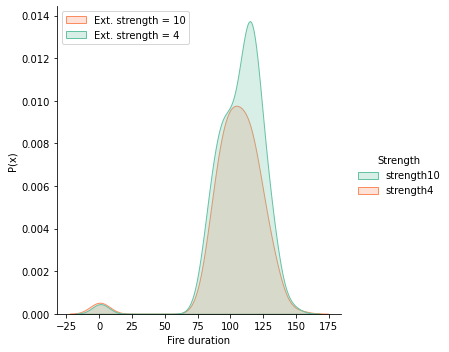

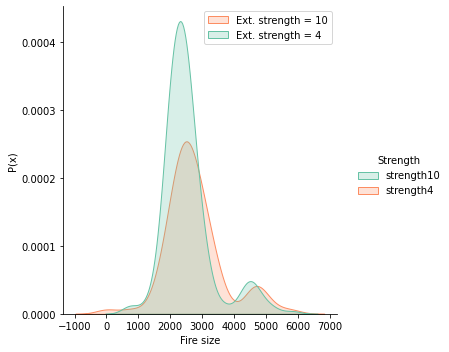

In [11]:
#Plot probabilities for certain durations and sizes
plt.figure(figsize=(12, 8))
sns.displot(data.loc[data['N_firefighters'] == 'nfighters300'], x='Duration', hue='Strength', fill=True, kind='kde')
plt.legend(['Ext. strength = 10','Ext. strength = 4'],loc='upper left')
plt.ylabel('P(x)')
plt.xlabel(f'Fire duration')
plt.savefig('duration_strength.jpg')


sns.displot(data.loc[data['N_firefighters'] == 'nfighters300'], x='FireSize', hue='Strength', fill=True, kind='kde')
plt.legend(['Ext. strength = 10','Ext. strength = 4'])
plt.ylabel('P(x)')
plt.xlabel(f'Fire size')
plt.savefig('size_strength.jpg')

In [251]:
# Set plot parameters
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['legend.fontsize'] = 16


array(['biggest', 'closest', 'earliest', 'random'], dtype=object)

biggest
4658
closest
3698
earliest
3709
random
3980


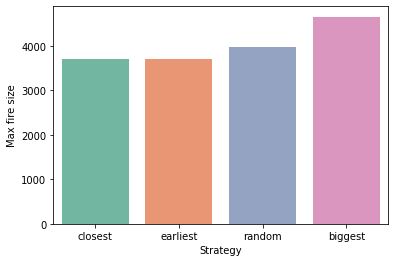

In [13]:
#Take correct data for plot and plot barplot for max fire size
data_help = data_counter[(data_counter['N_firefighters'] == 'nfighters300') & (data_counter['Strength'] == 'strength10')]
max_sizes = []
for strat in data_help['Strategy'].unique():
    size = data_help.loc[data_help['Strategy'] == strat,'Max area'].max()
    print(strat)
    print(size)
    max_sizes.append(size)

max_sizes.sort()
max_sizes
# sns.countplot(data=data[data['N_firefighters'] == 'nfighters300'], x='Strategy')
sns.barplot(x=['closest','earliest','random','biggest'],y=max_sizes)
plt.ylabel('Max fire size')
plt.xlabel(f'Strategy')
plt.savefig('strategy_maxsize.jpg')

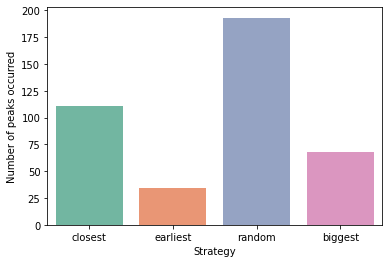

In [15]:
#Plot peak counts for different strategies
sns.countplot(data=data[data['N_firefighters'] == 'nfighters300'], x='Strategy',order=['closest','earliest','random','biggest'])
plt.ylabel('Number of peaks occurred')
plt.xlabel(f'Strategy')
plt.savefig('strategy_peakcount.jpg')

In [256]:
#Plot boxplots for different ext rates, for size and duration of fires
sns.boxplot(data=data.loc[data['N_firefighters'] == 'nfighters300'], x='Strength', y='FireSize')
plt.ylabel('Fire size')
plt.xlabel('Extinguishment strength')
plt.savefig('size_boxplot.jpg')
plt.show()

sns.boxplot(data=data.loc[data['N_firefighters'] == 'nfighters300'], x='Strength', y='Duration')
plt.ylabel('Duration')
plt.xlabel('Extinguishment strength')
plt.savefig('duration_boxplot.jpg')


9       0.025227
10      0.024319
11      0.023909
8       0.023766
12      0.022325
          ...   
1747    0.000005
1619    0.000005
3666    0.000005
3611    0.000005
2049    0.000005
Name: Max area, Length: 3362, dtype: float64

In [257]:
#plot dynamics for model without firefighters
no_fighter_data = data_counter.loc[data_counter['Strategy']=='No firefighters'][0:5000]
plt.figure(figsize=(12, 8))
plt.plot(no_fighter_data['Timestep'],no_fighter_data['Alive trees'],label='Trees')
plt.plot(no_fighter_data['Burning Trees'],label='Burning trees')
plt.legend()
plt.ylabel('Number of trees')
plt.xlabel(f't')
plt.savefig('dynamics.jpg')


-0.5598289442353971

<ipython-input-258-7190347456db>:1: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "or" (-> marker='o'). The keyword argument will take precedence.
  plt.loglog(y.index, y.values, 'or', marker='.', c='blue')
<ipython-input-258-7190347456db>:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "or" (-> color='r'). The keyword argument will take precedence.
  plt.loglog(y.index, y.values, 'or', marker='.', c='blue')


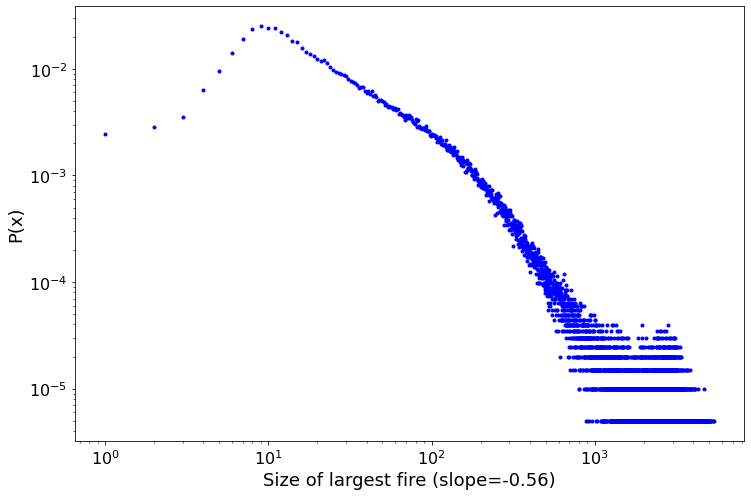

In [258]:
#Get frequencies for powe law graph
y = data_counter.loc[data_counter['Strategy'] == 'random','Max area'].value_counts(normalize=True)

#Regress to get slope
from scipy.stats import linregress
logx = np.log(y.values)
logy = np.log(y.index)

linregres_ = linregress(logx, logy).slope
linregres_

#Log log plot to show power law
plt.loglog(y.index, y.values, 'or', marker='.', c='blue')
plt.ylabel('P(x)')
plt.xlabel(f'Size of largest fire (slope={round(linregres_, 3)})')
plt.savefig('powerlaw.jpg')

